In [78]:
import sys
import random
import math
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import copy


device = "cuda" if torch.cuda.is_available() else "cpu"

In [79]:
# Takes a pandas dataset and preprocesses it
def preprocess(data):
  # Creating a new DataFrame with all columns except 'column2' and 'column4'
  columns_to_exclude = ['Day', 'Date', 'Time', 'Favorite', 'FavoriteTeamYear', 'UnderdogTeamYear',
                        'Score', 'Underdog', 'OverUnder', 'Season_Year', 'Favorite_Covered']
  X = data.drop(columns=columns_to_exclude)
  Y = data["Favorite_Covered"]

  # Convert time of posession columns to numbers
  for col_name in ['Favoriteaverage-time-of-possession-net-of-ot', 'Favoriteopponent-average-time-of-possession-net-of-ot', 'Underdogaverage-time-of-possession-net-of-ot', 'Underdogopponent-average-time-of-possession-net-of-ot']:
    col_data = X[col_name]
    new_col_data = []
    for row in col_data:
      split_data = row.split(':')
      col_data = 60*int(split_data[0]) + int(split_data[1])
      new_col_data.append(col_data)
    X[col_name] = new_col_data

  # Convert % to float
  for col_name in [
      "Favoritered-zone-scoring-pct", "Favoritethird-down-conversion-pct", "Favoritefield-goal-conversion-pct",
      "Favoriteopponent-red-zone-scoring-pct", "Favoriteopponent-third-down-conversion-pct", "Favoriteopponent-completion-pct",
      "Favoriteopponent-field-goal-conversion-pct", "Underdogred-zone-scoring-pct", "Underdogthird-down-conversion-pct",
      "Underdogfield-goal-conversion-pct", "Underdogopponent-red-zone-scoring-pct", "Underdogopponent-third-down-conversion-pct",
      "Underdogopponent-completion-pct", "Underdogopponent-field-goal-conversion-pct"
  ]:
    col_data = X[col_name]
    new_col_data = []
    for row in col_data:
      col_data = row[0:-1]
      new_col_data.append(col_data)
    X[col_name] = new_col_data

  # If there is not a reported spread, get rid of the row of data
  indices = []
  for i, row in enumerate(X['Spread']):
    if str(row) == 'nan':
      indices.append(i)
  X = X.drop(indices)
  Y = Y.drop(indices)


  # If there is a push and both sides of bet get their money back -set the label to T
  new_Y = []
  for row in Y:
    if row == 'T' or row == 'F':
      val = row
    else:
      val = 'T'
    new_Y.append(val)
  Y = pd.Series(new_Y)

  # Now scale the X dataset between 0 and 1
  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)

  # Do one hot encoding on Y
  label_mapping = {'F': 0, 'T': 1}
  numerical_labels = np.array([label_mapping[label] for label in Y])
  numerical_labels = numerical_labels.reshape(-1, 1)
  onehot_encoder = OneHotEncoder(sparse_output=False)
  y_transformed = onehot_encoder.fit_transform(numerical_labels)

  return X,y_transformed

In [80]:
class NFLDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.X,self.y= preprocess(data) # data is a pandas dataset
    self.len = self.X.shape[0]

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    X = torch.tensor(self.X,dtype=torch.float32)
    y = torch.tensor(self.y,dtype=torch.float32)
    return X[idx], y[idx]

In [81]:
def loadData(data, batch_size):
  D = NFLDataset(data)
  Dload = DataLoader(D, batch_size=batch_size, shuffle=True)
  return Dload

In [82]:
class DeepFeedForward(nn.Module):
  def __init__(self):
    super(DeepFeedForward, self).__init__()
    self.linear1 = nn.Linear(61, 256)
    self.relu1 = nn.LeakyReLU()
    self.linear2 = nn.Linear(256, 64)
    self.relu2 = nn.LeakyReLU()
    self.linear3 = nn.Linear(64, 32)
    self.relu3 = nn.LeakyReLU()

    #self.linear4 = nn.Linear(32, 2)
    #self.relu4 = nn.LeakyReLU()
    #self.linear5 = nn.Linear(8, 4)
    #self.relu5 = nn.LeakyReLU()

    self.linear_out = nn.Linear(32, 2)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)
    x = self.relu2(x)
    x = self.linear3(x)
    x = self.relu3(x)
    #x = self.linear4(x)
    #x = self.relu4(x)
    #x = self.linear5(x)
    #x = self.relu5(x)
    x = self.linear_out(x)
    return x

In [83]:
def train(dataloader, model, loss_func, optimizer):
  model.train()
  train_loss = []

  now = datetime.datetime.now()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_hat = torch.softmax(pred.reshape(-1,2), dim=1)
    #print(y_hat)
    loss = loss_func(y_hat, y)


    loss.backward() #Updates Gradients
    optimizer.step() #changes gradients
    optimizer.zero_grad() #Zeroes out gradients


    if batch % 100 == 0:

      #print("Y vs Yhat: ", y, y_hat)
      loss, current = loss.item(), batch * len(X)
      iters = 100 * len(X)
      then = datetime.datetime.now()
      iters /= (then - now).total_seconds()
      #print(f"loss: {loss:>6f} [{current:>5d}] ({iters:.1f} its/sec)")
      now = then
      train_loss.append(loss)
  return train_loss

def test(dataloader, model, loss_func):
  size = len(dataloader)
  num_batches = 0
  model.eval()
  test_loss = 0

  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      y_hat = torch.softmax(pred.reshape(-1,2), dim=1)
      test_loss += loss_func(y_hat, y)

      num_batches = num_batches + 1
  test_loss /= num_batches

  print(f"Avg Loss: {test_loss:>8f}\n")
  return test_loss

In [84]:
def pltLoss(train_loss,val_loss):
  plt_trainLossX = [i for i in range(len(train_loss))]
  plt_trainLossY = torch.tensor(train_loss).mean(axis=1)
  plt_valLossX = [i for i in range(len(val_loss))]
  plt_valLossY = val_loss
  plt.plot(plt_trainLossX, plt_trainLossY, label='train_loss')
  plt.plot(plt_valLossX, plt_valLossY, label='val_loss')
  plt.legend()
  plt.show

In [85]:
def trainIt(trainL, valL, model, loss, opt, epochs):
  train_loss = []
  val_loss = []
  for t in range(epochs):
    print(f"Epoch {t+1}\n------------------------------- \n")
    losses = train(trainL, model, loss, opt)
    train_loss.append(losses)
    val_loss.append(test(valL, model, loss))
  return train_loss, val_loss


#needs update
def testIt(testD, model):
  model.eval()
  predictedLabels = []
  trueLabels = []
  with torch.no_grad():
    for ex in testD:
      x, y = ex
      x, y = x.reshape(-1,61).to(device), y.to(device)
      pred = model(x)
      y = torch.argmax(y.data)
      _, predicted = torch.max(pred.data, 1)
      predictedLabels.append(int(predicted))
      trueLabels.append(int(y))

  cm = confusion_matrix(y_true = trueLabels, y_pred = predictedLabels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  f1 = f1_score(trueLabels, predictedLabels, average=None)
  hm = classification_report(trueLabels, predictedLabels, digits=2)
  return predictedLabels, cm, f1, hm

In [86]:
def softmax(x):
    # Subtract max for numerical stability
    x_exp = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
    soft_maxy = x_exp / torch.sum(x_exp, dim=1, keepdim=True)
    return soft_maxy

In [87]:
#Get an even training set (even F's and T's)
def get_even_datasets():
  dataset = pd.read_csv("sample_data/Final_Data_NFL.csv")
  train_df = dataset.sample(frac=0.7225, random_state=1)
  df_ones = train_df[train_df['Favorite_Covered'] == 'F']
  df_zeros = train_df[train_df['Favorite_Covered'] == 'T']
  min_length = min(len(df_ones), len(df_zeros))
  train_df = pd.concat([df_ones.sample(n=min_length, random_state=1),
                          df_zeros.sample(n=min_length, random_state=1)])
  validation_df, test_df = train_test_split(pd.concat([dataset, train_df]).drop_duplicates(keep=False), test_size = 0.5, random_state = 1)
  train_df = train_df.reset_index(drop = True)
  validation_df = validation_df.reset_index(drop = True)
  test_df = test_df.reset_index(drop = True)
  print("Train length: ", len(train_df)/len(dataset))
  print("Train label distribution: \n", train_df['Favorite_Covered'].value_counts())
  print("Val length: ", len(validation_df)/len(dataset))
  print("Test length: ", len(test_df)/len(dataset))
  return train_df, validation_df, test_df


In [88]:
def get_random_datasets(file_name, rs = 1):

  ##
  dataset = pd.read_csv(file_name)
  # Random sample:::
  # intermediate, test_df = train_test_split(dataset, test_size = 0.15, random_state = rs)
  # train_df, validation_df = train_test_split(intermediate, test_size = 0.15/0.85, random_state = rs)
  # train_df = train_df.reset_index(drop = True)
  # validation_df = validation_df.reset_index(drop = True)
  # test_df = test_df.reset_index(drop = True)
  # print("Train length: ", len(train_df)/len(dataset))
  # print("Train label distribution: \n", train_df['Favorite_Covered'].value_counts())
  # print("Val length: ", len(validation_df)/len(dataset))
  # print("Test length: ", len(test_df)/len(dataset))
  # return train_df, validation_df, test_df

  dataset = pd.read_csv(file_name)
  train_df, validation_df = train_test_split(dataset, test_size=0.15, random_state=rs)
  train_df = train_df.reset_index(drop=True)
  validation_df = validation_df.reset_index(drop=True)
  print("Train length: ", len(train_df)/len(dataset))
  print("Val length: ", len(validation_df)/len(dataset))
  return train_df, validation_df


Train length:  0.8498212157330155
Val length:  0.1501787842669845
Epoch 1
------------------------------- 

Avg Loss: 0.496444

Epoch 2
------------------------------- 

Avg Loss: 0.494762

Epoch 3
------------------------------- 

Avg Loss: 0.493080

Epoch 4
------------------------------- 

Avg Loss: 0.490747

Epoch 5
------------------------------- 

Avg Loss: 0.488434

Epoch 6
------------------------------- 

Avg Loss: 0.485122

Epoch 7
------------------------------- 

Avg Loss: 0.483219

Epoch 8
------------------------------- 

Avg Loss: 0.480479

Epoch 9
------------------------------- 

Avg Loss: 0.478884

Epoch 10
------------------------------- 

Avg Loss: 0.477622

Epoch 11
------------------------------- 

Avg Loss: 0.478448

Epoch 12
------------------------------- 

Avg Loss: 0.476994

Epoch 13
------------------------------- 

Avg Loss: 0.476604

Epoch 14
------------------------------- 

Avg Loss: 0.476168

Epoch 15
------------------------------- 

Avg Loss: 0.475293

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

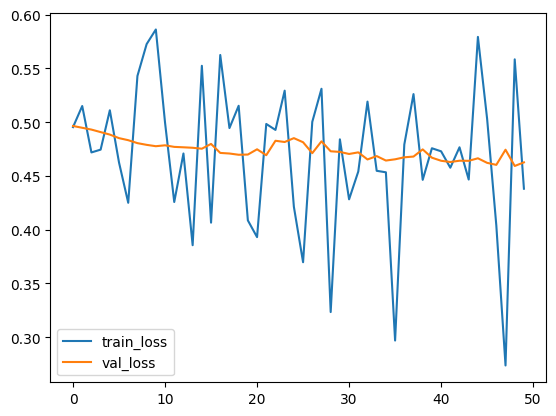

In [89]:
# Choose to make the training dataset even (same F's and T's) or to keep it unbalanced
#train_df, validation_df, test_df = get_even_datasets()

train_df, validation_df = get_random_datasets("sample_data/Final_Data_NFL.csv", rs = 1)

## FF, no regularization
ff = DeepFeedForward().to(device)
loss_func = nn.L1Loss() #Mean squared error loss function

#Specify learning rate. Weight decay is a regularizer
optimizer = torch.optim.Adam(ff.parameters(), lr=3e-5)

epochs = 50
train_loader = loadData(train_df, 1) #Batch size of 1
val_loader = loadData(validation_df, 1)


train_loss, val_loss = trainIt(train_loader, val_loader, ff, loss_func, optimizer, epochs)
pltLoss(train_loss, val_loss)

#final evaluation
test_df = pd.read_csv("sample_data/NFL_Predictions.csv")
testD = loadData(test_df, 1)
predictedLabels, cm, f1, hm = testIt(testD, ff)

for index, row in test_df.iterrows():
    #predicted_cover = predictions[index]  # Assuming this returns the team predicted to cover
    #print(f"Game {index + 1}: {row['Team1']} vs {row['Team2']} - Predicted to cover: {predicted_cover}")
    predicted_cover = 'Favorite' if predictedLabels[index] == 0 else 'Underdog'
    #print(f"Game {index + 1}: {row['Favorite']} vs {row['Underdog']} - Predicted to cover: {predicted_cover}")
    print(f"Game {index + 1}: {row['Favorite']} vs {row['Underdog']} - Predicted to cover: {predicted_cover}")
predLab, cm, f1, hm = testIt(testD, ff)
print('confusion matrix:\n', cm)
print('f1:\n', f1)
print('all info:\n', hm)